# Cancer Detection Kaggle Project

## Description of the Problem
This notebook attempts to use pictures of cancer cells to train a convolutional neural network to tell whether the cells are cancerous or not. This is obviously an important task, and it is made challenging by the scale of the data - roughly 220,000 images, a number which would likely take a human expert weeks or months to analyze. By using a trained supervised neural network, tens of thousands of images can be classified within minutes and at an accuracy approaching that of a human expert. Here I experiment with several neural network architectures to try to find the architecture which produces the highest accuracy rate.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import shutil
from matplotlib.image import imread

## Exploratory Data Analysis
I begin by taking a look at the data.

In [3]:
y_train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

We have 220,025 images in the training set. This creates its own challenges, as it was too many for Google Drive and colab to handle effectively. As a result, I run the notebook in Kaggle. 

In [4]:
len(y_train)

In [34]:
# take a look at what the ids look like
y_train['id'][:10]

In [6]:
y_train['label'].value_counts()

We can see that there are more labels of 0 - that is, more non-cancerous tissue samples in our training data. The imbalance  - roughly 60% to 40% - is not so great, however, as to require correcting. Let's take a look at some of the images.

In [7]:
#look at some images
fig, axs = plt.subplots(2,4,figsize=(15,15))

l = len(y_train)

for i in range(2):
    for j in range(4):
        num = random.randint(0,l)
        im = Image.open('../input/histopathologic-cancer-detection/train/'+os.listdir('../input/histopathologic-cancer-detection/train/')[num])
        lab = y_train[y_train.id==os.listdir('../input/histopathologic-cancer-detection/train/')[num].split('.')[0]].label
        axs[i,j].imshow(im)
        axs[i,j].set_title(str(lab))
        plt.tight_layout()

From looking at this sample of pictures, it seems like it would be very hard for a non-expert to identify the difference between cancerous and non-cancerous cells.

From the display, it also appears that our pictures are all the same size, 96 x 96.

## Building Data Generators
The sheer siz of the data means that it will be best to feed it in to the neural networks with a generator rather than try to keep the entire thing in memory. I opt to use the `flow_from_dataframe` method (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe) as we already have a data frame holding the ids of the pictures. I opt to set aside 10% of the images as a validation set. The large number of training images means that this will still be more than enough.

In [8]:
path = r'../input/histopathologic-cancer-detection/'
train_dir = r'../input/histopathologic-cancer-detection/train/'
test_dir = r'../input/histopathologic-cancer-detection/test/'

In [9]:
train_df = pd.read_csv(path + 'train_labels.csv',dtype=str)
train_df.id = train_df.id + '.tif'

In [10]:
img = train_dir + train_df.id[5]

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

In [12]:
datagen = ImageDataGenerator(rescale=1/255., validation_split=0.1)

train_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    color_mode = 'rgb',
    x_col = 'id',
    y_col = 'label',
    subset = 'training',
    batch_size = batch_size,
    seed = 1,
    shuffle = True,
    class_mode = 'binary',
    target_size = (96,96))

In [13]:
val_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    color_mode = 'rgb',
    x_col = 'id',
    y_col = 'label',
    subset = 'validation',
    batch_size = batch_size,
    seed = 1,
    shuffle = True,
    class_mode = 'binary',
    target_size = (96,96))

In [14]:
# set the number of steps
train_steps = np.ceil(len(train_gen) / batch_size)
val_steps = np.ceil(len(val_gen) / batch_size)

## The Model
With the geenrators set up, I can turn to the more fun part - building the model. I decided to go with three models. The first is a simple model with one module consisting of two convolution layers, a max pooling layer, and a dropout layer followed by a flattening layer and two dense layers. The inspiration for this came from the modules of VGG16 model, but I opted to make the module even simpler by having only two convolutional layers instead of three.

The second model is more complex, with 4 VGG16-inspired modules instead of one. It keeps the droput layers to try to prevent overfitting. The final model is probably the most prone to overfitting, as it is the same as the second model, but I remove the dropout layers. 

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [17]:
model1 = Sequential()
model1.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (96,96,3)))
model1.add(Conv2D(32, (3,3), activation = 'relu'))
model1.add(MaxPool2D(pool_size = (2,2))) 
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(32, activation = "relu"))
model1.add(Dropout(.2))
model1.add(Dense(1, activation = 'sigmoid'))

model1.summary()

In [18]:
model1.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [19]:
history1 = model1.fit(x = train_gen,
                   steps_per_epoch = train_steps,
                   validation_data = val_gen,
                   validation_steps = val_steps,
                   epochs = 10)

The simple model did quite well, with a validation accuracy of around 0.8. It is time to see if upping the complexity improves the validation accuracy.

In [20]:
model2 = Sequential()
model2.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (96,96,3)))
model2.add(Conv2D(32, (3,3), activation = 'relu'))
model2.add(MaxPool2D(pool_size = (2,2))) 
model2.add(Dropout(0.2))

model2.add(Conv2D(64, (3,3), activation = 'relu'))
model2.add(Conv2D(64, (3,3), activation = 'relu'))
model2.add(MaxPool2D(pool_size = (2,2))) 
model2.add(Dropout(0.2))

model2.add(Conv2D(128, (3,3), activation = 'relu'))
model2.add(Conv2D(128, (3,3), activation = 'relu'))
model2.add(MaxPool2D(pool_size = (2,2))) 
model2.add(Dropout(0.2))

model2.add(Conv2D(256, (3,3), activation = 'relu'))
model2.add(Conv2D(256, (3,3), activation = 'relu'))
model2.add(MaxPool2D(pool_size = (2,2))) 
model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))
model2.add(Dropout(.2))
model2.add(Dense(1, activation = 'sigmoid'))

model2.summary()

In [21]:
model2.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [22]:
history2 = model2.fit(x = train_gen,
                   steps_per_epoch = train_steps,
                   validation_data = val_gen,
                   validation_steps = val_steps,
                   epochs = 10)

The more complex model with 4 modules has a much lower validation accuracy. This is surprising, actually, because I had included dropout layers to try to prevent overfitting. Perhaps I need to increase the dropout rate. But first I will see, in `model3`, how getting rid of the dropout layers altogether affects validation accuracy.

In [23]:
model3 = Sequential()
model3.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (96,96,3)))
model3.add(Conv2D(32, (3,3), activation = 'relu'))
model3.add(MaxPool2D(pool_size = (2,2))) 

model3.add(Conv2D(64, (3,3), activation = 'relu'))
model3.add(Conv2D(64, (3,3), activation = 'relu'))
model3.add(MaxPool2D(pool_size = (2,2))) 

model3.add(Conv2D(128, (3,3), activation = 'relu'))
model3.add(Conv2D(128, (3,3), activation = 'relu'))
model3.add(MaxPool2D(pool_size = (2,2))) 

model3.add(Conv2D(256, (3,3), activation = 'relu'))
model3.add(Conv2D(256, (3,3), activation = 'relu'))
model3.add(MaxPool2D(pool_size = (2,2))) 

model3.add(Flatten())
model3.add(Dense(256, activation = "relu"))
model3.add(Dense(1, activation = 'sigmoid'))

model3.summary()

In [24]:
model3.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [25]:
history3 = model3.fit(x = train_gen,
                   steps_per_epoch = train_steps,
                   validation_data = val_gen,
                   validation_steps = val_steps,
                   epochs = 10)

This model also performs much more poorly than the simplest `model1`. Below I graph the accuracy of the models. It is clear that `model1` did the best.

In [36]:
def plot_graphs(history, string, title):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history1, 'accuracy', 'Model 1')
plot_graphs(history2, 'accuracy', 'Model 2')
plot_graphs(history3, 'accuracy', 'Model 3')

## Predicting on the Test Set
Although it seems that `model1` is the best, I submitted both it and `model3` to the competition, and `model3` actually performed the best on the test set, so below I show the code to generate predictions on the test set with the most complex model (`model3`).

In [27]:
test_df = pd.read_csv(path + 'sample_submission.csv')
test_df['filename'] = test_df.id + '.tif'

In [28]:
datagen_test = ImageDataGenerator(rescale=1/255.)

test_gen = datagen_test.flow_from_dataframe(
    dataframe = test_df,
    directory = test_dir,
    color_mode = 'rgb',
    x_col = 'filename',
    batch_size = 32,
    seed = 1,
    shuffle = False,
    class_mode = None,
    target_size = (96,96))

In [29]:
test_steps = np.ceil(len(test_gen) / batch_size)
test_images_path = len(os.listdir(test_dir))

In [30]:
predictions = model3.predict(test_gen, verbose=1)

In [32]:
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')
submission.label = predictions

In [33]:
submission.to_csv('./cancer_submission.csv')

The model got a score of 0.8625 - quite respectable for such a simple model, I think!

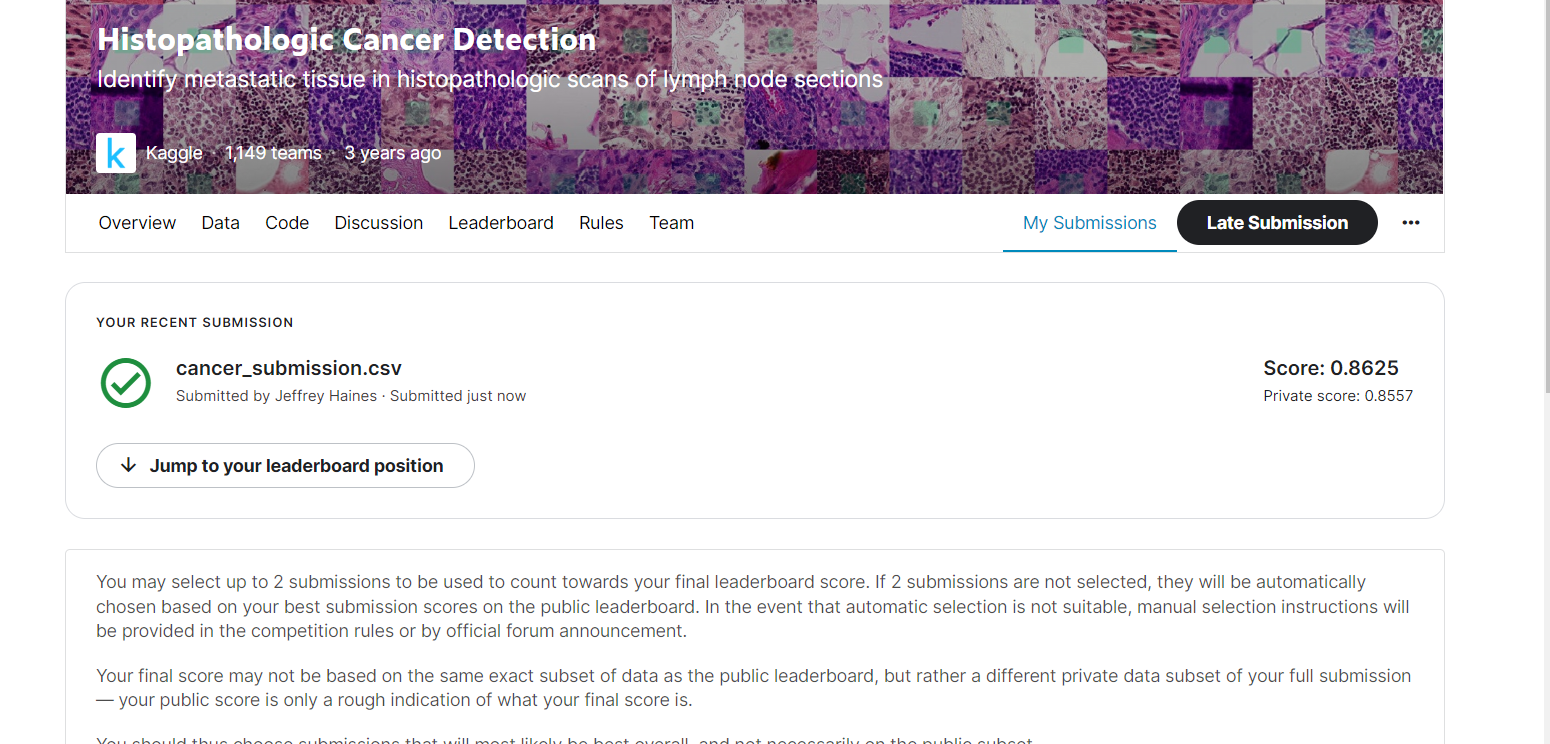

## Conclusion
Overall the most complex architecture had the highest accuracy on the test set. Regularizing via dropout to prevent overfitting really did not do much to improve test set accuracy. Since the most complex model had the best performance, I might try increasing the model complexity by adding more convolutional and pooling layers, as it is possible that there is more complexity in the images that I am still not capturing. 
